In [23]:
import pandas as pd
import plotly.express as px
from src.config import BaseConfig

config = BaseConfig()
vs = {"renderer": "svg", "width": 1000, "height": 500}

In [24]:
# data = pd.read_json(config.processed_data_dir / "final_data_to_train.json")
data = pd.read_json(config.interim_data_dir / "cleaned_enriched_jira_tasks.json")

In [25]:
data["jira_created"] = pd.to_datetime(data["jira_created"])

data.head(0)

,assignee_email,assignee_level_order,jira_created,jira_description,jira_key,jira_title,slack_link,time_to_complete_hours,weeks_since_member_join,slack_thread_messages


# <b>Overview of the data

In [26]:
data["assignee_email"] = data.assignee_email.apply(lambda x: f"{str(abs(hash(x)))[:4]}@hashed-mail.com")

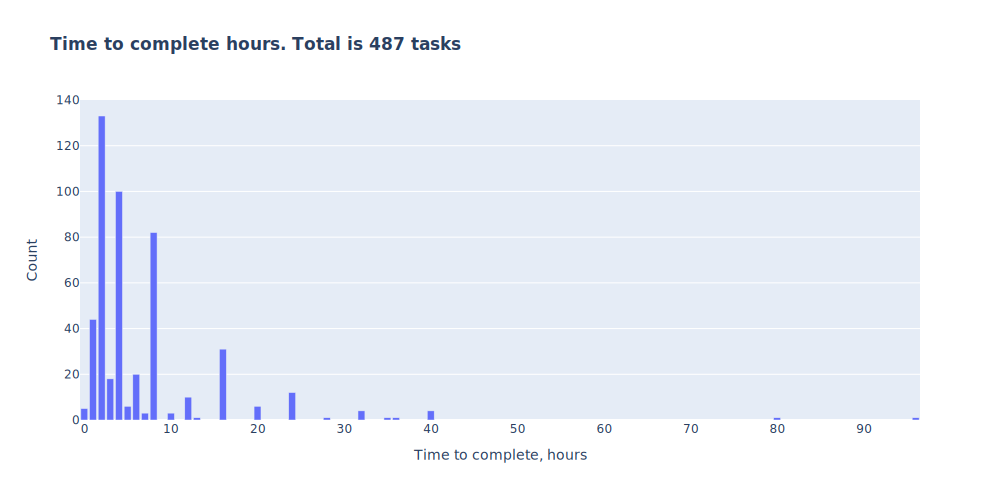

In [27]:
# Most tasks were resolved within 2 hours.
# The most common time values for task completion
# are 1, 2, 4, 8, and 16 hours, which reflect the planning and estimation process.

px.bar(
    data.time_to_complete_hours.value_counts().reset_index(),
    x="time_to_complete_hours",
    y="count",
    title=f"<b>Time to complete hours. Total is {data.shape[0]} tasks</b>",
    labels={"time_to_complete_hours": "Time to complete, hours", "count": "Count"},
).show(**vs)

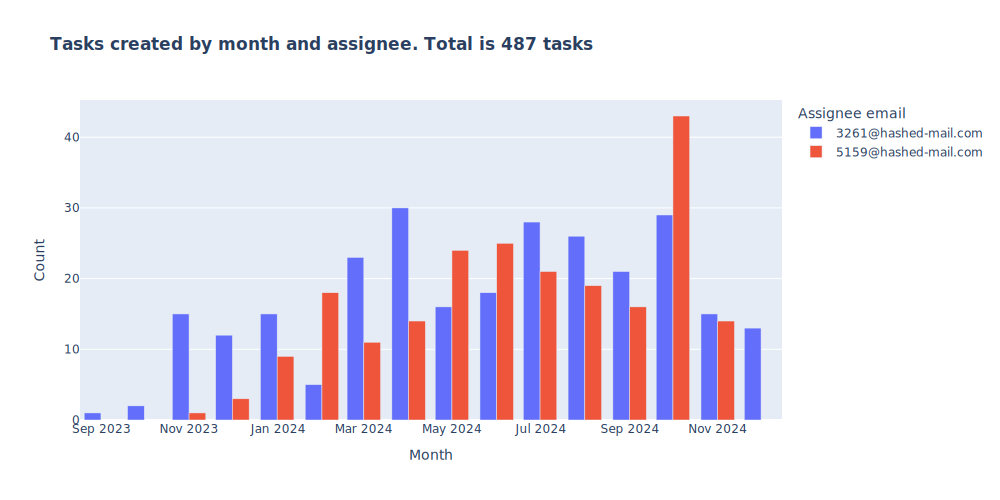

In [28]:
# This chart highlights trends that strongly correlate with team members'
# feedback about workload.
# Members with higher experience and longer tenure in the team tend to handle more tasks.


data["month"] = data.jira_created.dt.tz_localize(None).dt.to_period("M").dt.to_timestamp()
gdf = data.groupby(["month", "assignee_email"]).size().reset_index()
gdf.columns = ["month", "assignee_email", "count"]

px.bar(
    gdf,
    x="month",
    y="count",
    color="assignee_email",
    title=f"<b>Tasks created by month and assignee. Total is {data.shape[0]} tasks</b>",
    labels={"month": "Month", "count": "Count", "assignee_email": "Assignee email"},
    barmode="group",
).show(**vs)



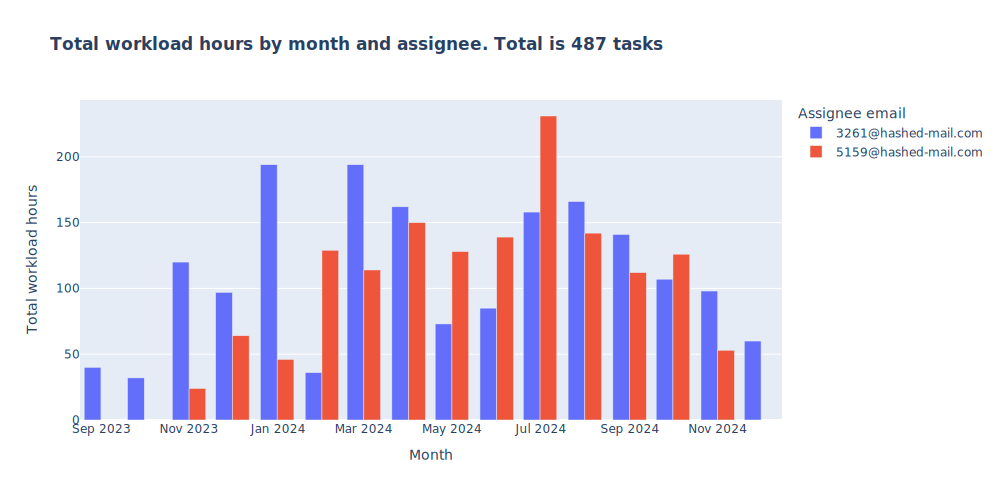

In [29]:
# Based on this chart and the previous one, we can infer a trend
# of underestimating the workload for team members.
# While the team provides feedback indicating a high workload,
# the charts reveal a decreasing trend in total workload, both in hours and tasks, over time.


data["month"] = data.jira_created.dt.tz_localize(None).dt.to_period("M").dt.to_timestamp()
gdf = data.groupby(["month", "assignee_email"]).time_to_complete_hours.sum().reset_index()
gdf.columns = ["month", "assignee_email", "total_workload_hours"]

px.bar(
    gdf,
    x="month",
    y="total_workload_hours",
    color="assignee_email",
    title=f"<b>Total workload hours by month and assignee. Total is {data.shape[0]} tasks</b>",
    labels={"month": "Month", "total_workload_hours": "Total workload hours", "assignee_email": "Assignee email"},
    barmode="group",
).show(**vs)

# <b> Overview of jira task length

In [30]:
final_data = pd.read_json(config.processed_data_dir / "final_data_to_train.json")

In [31]:
final_data.head(0)

,assignee_level_order,jira_key,weeks_since_member_join,time_to_complete_hours,task_text


In [32]:
final_data["task_text_length"] = final_data.task_text.apply(lambda x: len(x.split()))

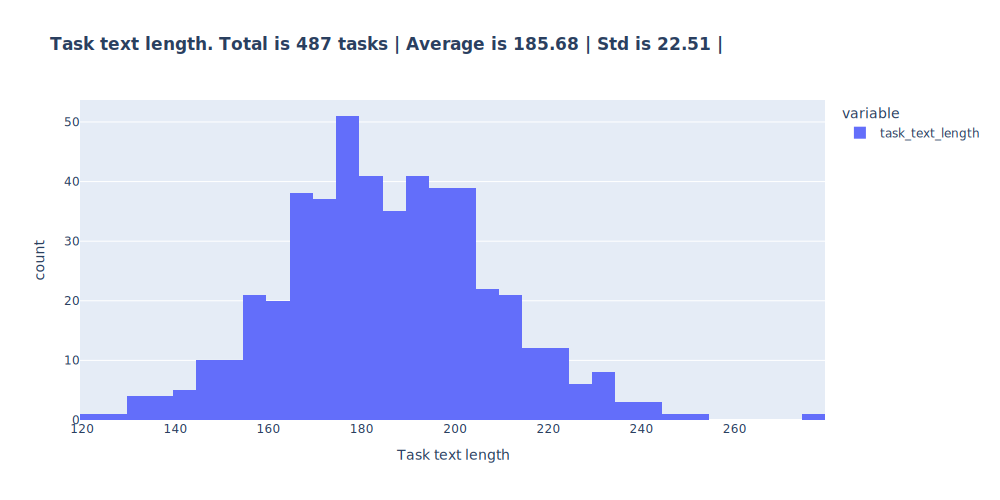

In [34]:
# The average task text length is 186 words. The standard deviation is 23 words.
# The histogram shows that most tasks have a text length of 130 to 240 words.

px.histogram(
    final_data.task_text_length,
    title=f"<b>Task text length. Total is {final_data.shape[0]} tasks | "
          f"Average is {final_data.task_text_length.mean():.2f} | "
          f"Std is {final_data.task_text_length.std():.2f} | ",
    labels={"value": "Task text length", "count": "Count"},
).show(**vs)

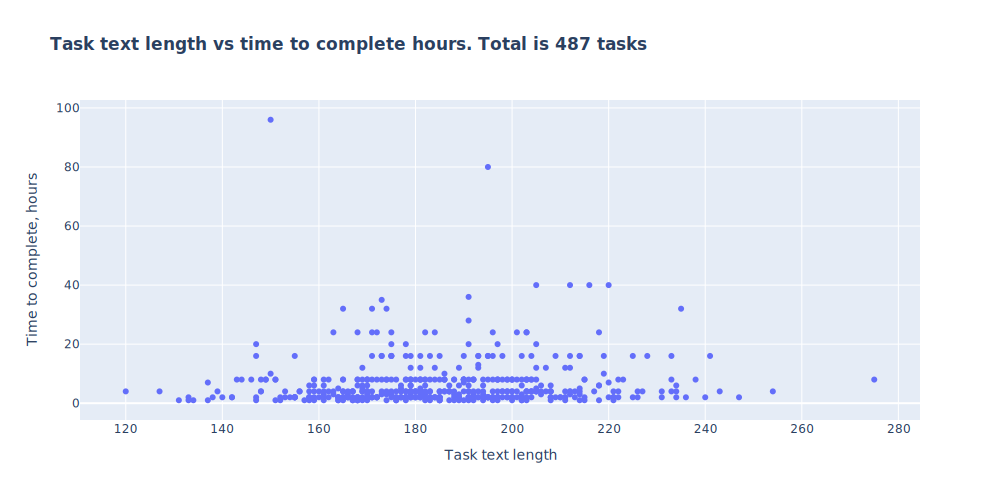

In [35]:
# There are no significant trends in the relationship between task text
# length and time to complete.


px.scatter(
    final_data,
    x="task_text_length",
    y="time_to_complete_hours",
    title=f"<b>Task text length vs time to complete hours. Total is {final_data.shape[0]} tasks</b>",
    labels={"task_text_length": "Task text length", "time_to_complete_hours": "Time to complete, hours"},
).show(**vs)